# Computational Challenge 2
*Model 1:* Quasi-stationary distributions in the birth-death model.


*Group 2:* Daniel, Thuyen, Danial, and Manoj.

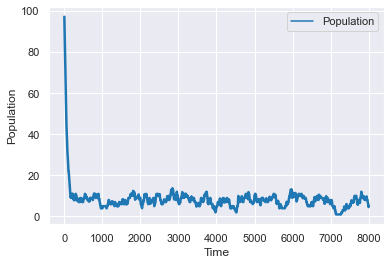

In [1]:
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib.pyplot as plt

# sns.set(style="whitegrid")



# Function: Change of Population 
def changePop(b,d):
    r = np.random.random_sample()
    if r < b:
        return 1
    elif r > (b+d):
        return 0
    else:
        return -1

    
    
# Function: Find Probability of Birth/Dearth/None
def findProp(i):
    b = r*(i - np.power(i,2)/N)
    d = r*np.power(i,2)/N
    return b,d



# Generate and plot one population trajectory
#--- Intial Parameters
# r = 0.004
# K = 50
r = 0.015
K = 8
t = 8000
P0 = 100 # Initial population

N = 2*K
pop = np.zeros(t)
pop[0] = P0

#--- Generate population
for k in range(t-1):
    if pop[k] < 1:
        break
    else:
        b,d = findProp(pop[k])
        pop[k+1] = pop[k] + changePop(b,d)


#--- Plot
time = np.linspace(0,t-1,t)
time_pop = pd.DataFrame(pop,time,["Population"])
time_pop = time_pop.rolling(7).mean()
#ax = sns.lineplot(x="Time", y="Population", data=time_pop, palette="tab10", linewidth=2.5)
ax = sns.lineplot(data=time_pop,palette="tab10", linewidth=2.5)
ax.set(xlabel='Time', ylabel='Population')
plt.show()



# Find the extinction time
